<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/DL_MovieReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries/Dataset

### Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive

import pandas as pd
import numpy as np
import random as rd

from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from matplotlib import pyplot as plt

In [2]:
rd.seed(2020)         # Initialize the random number generator.
np.random.seed(2020)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2020)  # sets the graph-level random seed

### Import Dataset

Loading the dataset using the 
[TFDS Github](https://github.com/tensorflow/datasets)

In [3]:
train_data, test_data = tfds.load(name="imdb_reviews", 
                                  split=["train","test"],
                                  batch_size=-1, 
                                  as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL324X0/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL324X0/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL324X0/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
X_train, y_train = tfds.as_numpy(train_data)
X_test, y_test = tfds.as_numpy(test_data)

### Check GPU

In [5]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

get_available_gpus()

['/device:GPU:0']

## Data Visualization

### Print Reviews

Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text

In [6]:
pos_sent = [ X_train[i] for i,v in enumerate(y_train) if v==1]
neg_sent = [ X_train[i] for i,v in enumerate(y_train) if v==0]

In [7]:
for pos,neg in list(zip(pos_sent,neg_sent))[:2]:
  print("*"*50)
  print("Postive Sentence:",pos,"\n")
  print("Negative Sentence:",neg,"\n")

**************************************************
Postive Sentence: b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.' 

Negative Sentence: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared p

### Plot Class Distribution

Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment.

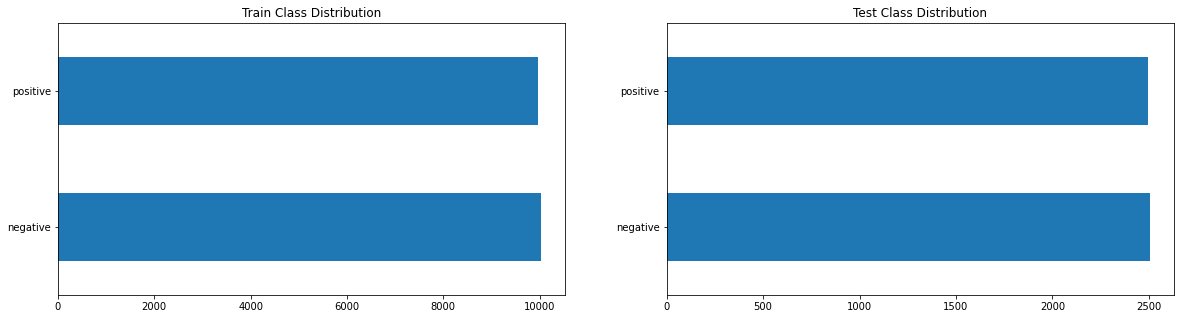

In [8]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
df_y_train = pd.DataFrame(y_train,columns=['label'])
df_y_train['sentiment'] = df_y_train['label'].apply(lambda x: 'positive' if x == 1 else 'negative')
df_y_train['sentiment'].value_counts().plot(kind='barh',title='Train Class Distribution',ax=ax[0])

df_y_test = pd.DataFrame(y_test,columns=['label'])
df_y_test['sentiment'] = df_y_test['label'].apply(lambda x: 'positive' if x == 1 else 'negative')
df_y_test['sentiment'].value_counts().plot(kind='barh',title='Test Class Distribution',ax=ax[1])

### Print the shapes of train and test data

In [9]:
print('Train Features shape:',X_train.shape)
print('Test Features shape:',X_test.shape)
print('Train label shape:',y_train.shape)
print('Test label shape:',y_test.shape)

Train Features shape: (20000,)
Test Features shape: (5000,)
Train label shape: (20000,)
Test label shape: (5000,)


## Data Pre-processing

Need for this Step - Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step.

Using the Pretrained embedding layer to convert the sentence to vector

In [10]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",output_shape=128,
                           input_shape=[], dtype=tf.string)

## Modeling

### Model Building

Sequential Model layers

In [11]:
model = keras.Sequential()


1.   Add L2 regularization to all the layers.
2.   Add one layer of dropout at the appropriate position and give reasons.
3.   Choose the appropriate activation function for all the layers.

In [12]:
model.add(hub_layer)

model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)) )

model.add(keras.layers.Dense(32, activation='relu'))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(16, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

Print the model summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               249285376 
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 249,296,257
Trainable params: 10,881
Non-trainable params: 249,285,376
_____________________________________

### Model Compilation

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,name='Adam'),#Use an appropriate optimizer
              loss='binary_crossentropy',#appropriate loss function
              metrics=['accuracy'])#Use accuracy as metric

In [17]:
history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=50,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/40
320/320 [==============================] - 2s 7ms/step - loss: 0.4839 - accuracy: 0.7862 - val_loss: 0.4750 - val_accuracy: 0.7925
Epoch 2/40
320/320 [==============================] - 2s 7ms/step - loss: 0.4698 - accuracy: 0.7964 - val_loss: 0.4740 - val_accuracy: 0.7947
Epoch 3/40
320/320 [==============================] - 2s 7ms/step - loss: 0.4628 - accuracy: 0.8019 - val_loss: 0.5046 - val_accuracy: 0.7595
Epoch 4/40
320/320 [==============================] - 2s 6ms/step - loss: 0.4609 - accuracy: 0.8031 - val_loss: 0.4700 - val_accuracy: 0.7933
Epoch 5/40
320/320 [==============================] - 2s 6ms/step - loss: 0.4630 - accuracy: 0.8011 - val_loss: 0.4884 - val_accuracy: 0.7895
Epoch 6/40
320/320 [==============================] - 2s 6ms/step - loss: 0.4617 - accuracy: 0.7989 - val_loss: 0.4767 - val_accuracy: 0.7795
Epoch 7/40
320/320 [==============================] - 2s 6ms/step - loss: 0.4544 - accuracy: 0.8074 - val_loss: 0.4717 - val_accuracy: 0.7875
Epoch 

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

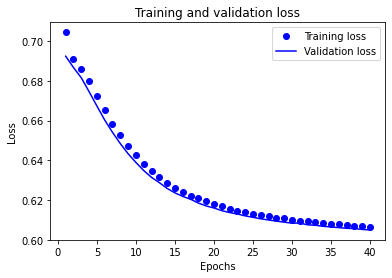

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

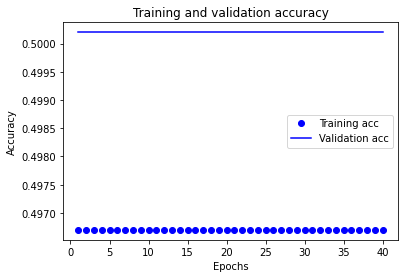

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model Evaluation

Print the final test/validation loss and accuracy

In [28]:
results = model.evaluate(X_test, y_test)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

157/157 [==============================] - 1s 4ms/step - loss: 0.4630 - accuracy: 0.7962
Test Loss: 0.46296781301498413
Test Accuracy: 0.7961999773979187


In [23]:
#Predictions
y_pred = model.predict_classes(X_test)

Confusion Matrix

In [30]:
print("Confustion Matrix")
print(confusion_matrix(y_test,y_pred))

Confustion Matrix
[[1991  514]
 [ 505 1990]]


Classification Report

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2505
           1       0.79      0.80      0.80      2495

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



**Write a summary for the best and worst performing class and the overall trend??**